# 🔮 Forcasting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/Twist2

/content/gdrive/MyDrive/Twist2


## Load libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

## Plot font settings

In [4]:
# Adjust figure font sizes for better appearance
plt.rc('font', size=16) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=16) #fontsize of the x tick labels
plt.rc('ytick', labelsize=16) #fontsize of the y tick labels
plt.rc('legend', fontsize=14) #fontsize of the legend

## Avaliable air polluion monitoring sites

In [5]:
Site_Names = ['AJ_Jacobs','Bongani_Mabaso_Eco_Park','Leitrim','North_West_University_Vaal_campus','Sharpeville','Vanderbijlpark_NAQI','Zamdela_NAQI']


## Load data from database and select site



In [6]:
import sqlite3
import csv

con = sqlite3.connect("air_pollution_database.db")
cur = con.cursor()

site = Site_Names[5]
print(site)

df = pd.read_sql(f'SELECT * FROM {site}',con)

con.close()

df['datetime'] = df.year.astype(str)+'-'+df.month.astype(str)+'-'+df.day.astype(str)+' '+df.time.astype(str)+':00:00'
df['datetime'] = pd.to_datetime(df['datetime'])

df = df.sort_values(by='datetime')

# print(df.info())
# print(df.head())
# print(df.tail())

Vanderbijlpark_NAQI


## Avaliable air pollutants

In [7]:
if site == Site_Names[0]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'CO', 'PM2_5', 'PM10']
elif site == Site_Names[1]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'PM2_5', 'PM10']
elif site == Site_Names[2]:
  Pollutants = ['SO2', 'NO2', 'PM2_5', 'PM10']
elif site == Site_Names[3]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'PM2_5', 'PM10']
elif site == Site_Names[4]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'PM2_5', 'PM10']
elif site == Site_Names[5]:
  Pollutants = ['SO2','O3', 'PM2_5', 'PM10']
elif site == Site_Names[6]:
  Pollutants = ['SO2', 'NO2', 'NO', 'NOx', 'O3', 'CO', 'PM2_5', 'PM10']
else:
  print('Error: No valid site selected')

## Main dataframe containing historical data

In [8]:
df_new = df[Pollutants+['time','day','month','year','datetime']]
df_new = df_new.mask(df == '')
df_new.dropna(thresh=len(Pollutants), inplace=True)

forcast_begin = pd.to_datetime('2022-03-01 01:00:00') 
forcast_end = pd.to_datetime('2022-03-07 23:00:00')#forcast_begin + pd.to_timedelta(24, unit='h') #


#print(df_new.info())
#print(df_new.head())
#print(df_new.tail())

## Dataframe to hold forcasted data

In [9]:
df_forcast = df_new.loc[(df_new['datetime']<= forcast_begin)]
df_forcast.info()
N = len(df_forcast)

current_time = forcast_begin + pd.to_timedelta(1, unit='h')
# df_forcast = df_forcast.append(df_new.loc[(df_new['datetime']== current_time)], ignore_index=True) 
# current_time = current_time  + pd.to_timedelta(1, unit='h')
# df_forcast = df_forcast.append(df_new.loc[(df_new['datetime']== current_time)], ignore_index=True) 
# current_time = current_time  + pd.to_timedelta(1, unit='h')

while current_time <= forcast_end:
  df_dummy = pd.DataFrame(
      [[current_time, current_time.year, current_time.month,current_time.day,current_time.hour]],
       columns=['datetime','year','month','day','time'])
  df_forcast = df_forcast.append(df_dummy, ignore_index=True)
  current_time +=  pd.to_timedelta(1, unit='h')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36458 entries, 19199 to 18960
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SO2       30483 non-null  object        
 1   O3        13350 non-null  object        
 2   PM2_5     20140 non-null  object        
 3   PM10      30159 non-null  object        
 4   time      36458 non-null  int64         
 5   day       36458 non-null  int64         
 6   month     36458 non-null  int64         
 7   year      36458 non-null  int64         
 8   datetime  36458 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 2.8+ MB


## Pop datetime column

In [11]:
df_new_datetime = df_new.pop('datetime')
df_forcast_datetime = df_forcast.pop('datetime')

In [12]:
df_forcast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36624 entries, 0 to 36623
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SO2     30483 non-null  object
 1   O3      13350 non-null  object
 2   PM2_5   20140 non-null  object
 3   PM10    30159 non-null  object
 4   time    36624 non-null  int64 
 5   day     36624 non-null  int64 
 6   month   36624 non-null  int64 
 7   year    36624 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 2.2+ MB


## Data preparation helper function

In [13]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
  ''' Function to convert dataframe for use in supervised multivariate time series 
	machine learning learning task.

	Parameters
	---------------
	df:	pandas dataframe
		df is a dataframe containing time sereis data
	n_in:	int, default 1
		number of past time steps in
	n_out: int, default 1
		number of future time steps out

	Returns
	--------------
	agg: pandas dataframe
		prepared data
	'''

	n_vars = 1 if type(df) is list else len(df.columns)
	cols, names = list(), list()
	# Input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# Forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# Put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# Drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



## Load scaling and model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Load scaling
import joblib
scaler_filename = 'scaler_'+site+'.save'
scaler = joblib.load(scaler_filename)

from tensorflow import keras
model = keras.models.load_model('Model'+site)

## Forcast into the future

In [15]:
for i in tqdm(range(N,len(df_forcast)-1,1)):

  # Normalize features
  df_scaled = scaler.fit_transform(df_forcast.loc[0:i+1,:].to_numpy()) 
  df_scaled = pd.DataFrame(df_scaled, columns=Pollutants+['time','day','month','year'])

  # Frame as supervised learning
  reframed = series_to_supervised(df_scaled, 1, 1, dropnan=False) 
  # Drop columns we don't want to predict
  reframed.drop(reframed.columns[[len(reframed.columns)-4,len(reframed.columns)-3,len(reframed.columns)-2,len(reframed.columns)-1]], axis=1, inplace=True)
  reframed.dropna(inplace=True)

  test = reframed.values
  test = test.astype('float32')
  test_X   = test[: , :-len(Pollutants)]
  test_X  = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  # Make a prediction
  yhat = model.predict(test_X)

  # Invert scaling
  test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  inv_yhat = np.concatenate((yhat, test_X_reshaped[:, len(Pollutants):]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)

  # Add new prediction to forcast dataframe
  df_forcast.loc[[i+1],Pollutants] = inv_yhat[-1][0:len(Pollutants)]


100%|██████████| 165/165 [00:48<00:00,  3.41it/s]


## Check forcast was successful

In [17]:
print(df_forcast.tail())

            SO2        O3      PM2_5        PM10  time  day  month  year
36619  8.882155  6.301096  60.649773   121.53595    19    7      3  2022
36620  8.404878  6.598252  58.692268  118.653542    20    7      3  2022
36621  7.934289  6.853294  56.866615  115.922607    21    7      3  2022
36622  7.528026  7.078098  55.296661  113.562988    22    7      3  2022
36623  7.161332  7.308732  53.833836  111.274254    23    7      3  2022


## Plot forcasted values

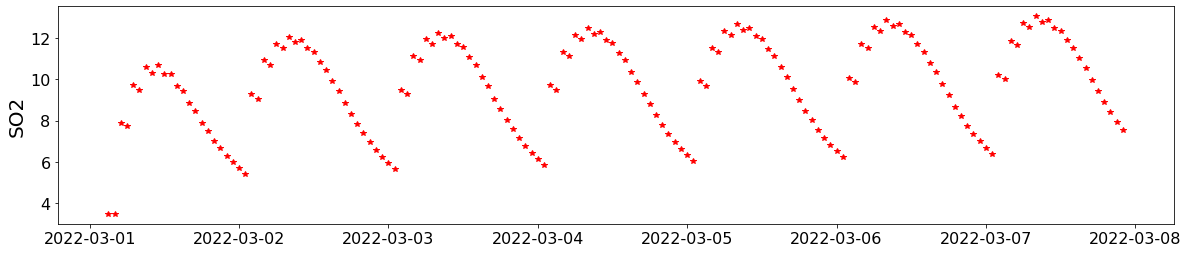

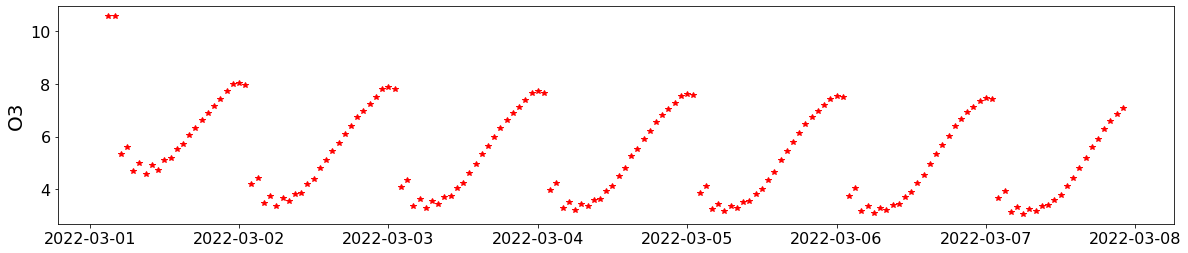

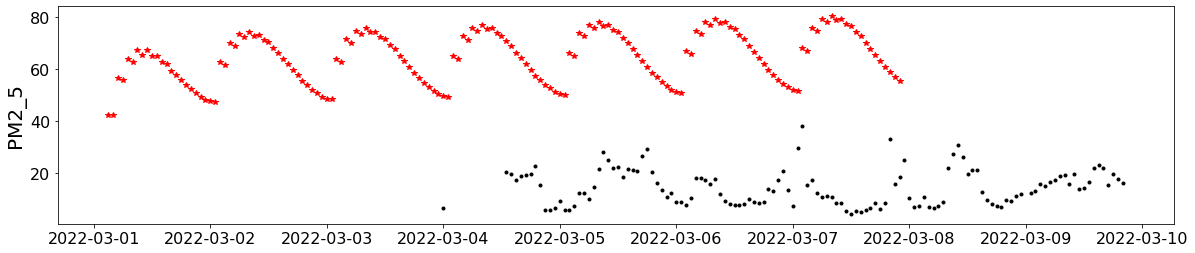

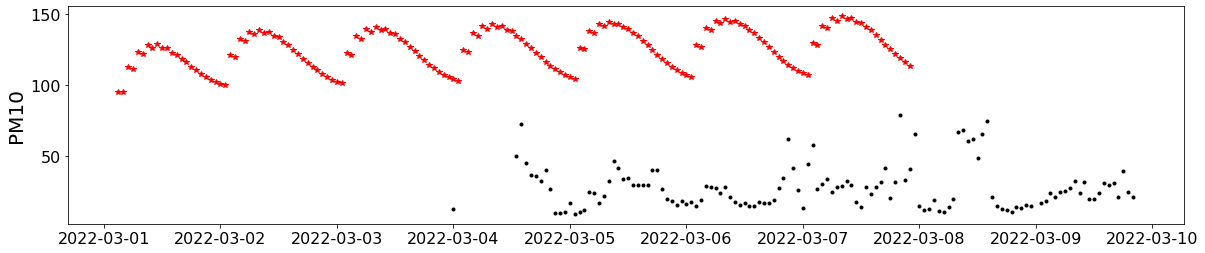

In [18]:

for pol in Pollutants:
  plt.figure(figsize=(20,4))
  plt.plot(df_forcast_datetime[N:-1], df_forcast[pol][N:-1],'*r',label='Measured (unseen)')
  plt.plot(df_new_datetime[N+1:-1], df_new[pol][N+1:-1],'.k',label='Forcasted')
  plt.ylabel(pol)
  plt.legend()

  # calculate RMSE
  #y_true = np.array(df_new[pol][-7*24:])
  #g_ind = np.argwhere(pd.isna(y_true) == False  )
  #g_ind = g_ind.reshape(g_ind.shape[0])
  # print(g_ind)
  #if len(g_ind>0):
    #rmse = np.sqrt(mean_squared_error(y_true[g_ind], df_pred[pol][g_ind]))
    #print('Test RMSE: %.3f' % rmse)
  #plt.savefig('Model'+site+'/'+site+pol+'_24hr_pred')
plt.show()



## Save forcasted values

In [19]:
df_save = df_forcast.copy()
df_save['datetime'] =  df_forcast_datetime
df_save= df_save.loc[(df_save['datetime']>= forcast_begin)]

df_save.info()

df_save.to_csv(site+'_forcast.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167 entries, 36457 to 36623
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   SO2       165 non-null    object        
 1   O3        165 non-null    object        
 2   PM2_5     165 non-null    object        
 3   PM10      165 non-null    object        
 4   time      167 non-null    int64         
 5   day       167 non-null    int64         
 6   month     167 non-null    int64         
 7   year      167 non-null    int64         
 8   datetime  167 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 13.0+ KB
